# Generate Predictions Images for a Site over Time
This notebook is used to generate predictions overlays for a given location.

Outputs are saved pngs where prediction score controls the opacity of a single-color image. The script also generates RGB patches for each prediction as well.

In [1]:
import os
import sys

import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from tensorflow import keras
from tqdm import tqdm

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [83]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

In [309]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.035
site_coords = [115.350242, -8.562121]
name = 'temesi'

In [ ]:
patch_history = get_history([site_coords], 
                            [name], 
                            rect_width,
                            num_months = 65,
                            start_date = '2015-08-01')

## Generate Predictions

In [311]:
# Select model to load for predictions
model = keras.models.load_model('../models/65_mo_tpa_bootstrap_toa-12-20-2020.h5')

In [312]:
def normalize(array):
    return np.array(array) / 3000

def predict_time_series(patch_histories, site_name, model):
    rgb_stack = []
    preds_stack = []
    dates_list = []
    
    dates = list(patch_histories.keys())
    for date in tqdm(dates):
        rgb = np.stack((patch_histories[date][site_name]['B4'],
                        patch_histories[date][site_name]['B3'],
                        patch_histories[date][site_name]['B2']), axis=-1)
        
        width, height = rgb.shape[:2]
        pixel_vectors = []
        for i in range(width):
            for j in range(height):
                pixel_vector = []
                for band in band_descriptions:
                    pixel_vector.append(patch_histories[date][site_name][band][i][j])
                pixel_vectors.append(pixel_vector)
        
        pixel_vectors = normalize(pixel_vectors)
        if len(pixel_vectors) > 0 and np.median(rgb) > 0.1:
            rgb_stack.append(rgb / 3000)
            preds = model.predict(np.expand_dims(pixel_vectors, axis=-1))
            preds_img = np.reshape(preds, (width, height, 2))[:,:,1]
            preds_stack.append(preds_img)
            dates_list.append(date)
            
    return np.array(rgb_stack), np.array(preds_stack), dates_list

In [313]:
rgb_stack, preds_stack, dates_list = predict_time_series(patch_history, 'temesi', model)

100%|██████████| 70/70 [03:11<00:00,  2.73s/it]


In [314]:
def green_blue_swap(image):
    # to play nicely with OpenCV's BGR color order
    r,g,b = cv2.split(image)
    image[:,:,0] = b
    image[:,:,1] = g
    image[:,:,2] = r
    return image

In [315]:
def filter_small_points(image):
    # This is experimental. Filter out "hot pixel" predictions
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    mask = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    out = image * mask
    return out

In [320]:
def stretch_histogram(array, min_val, max_val):
    clipped = np.clip(rgb_stack[0], min_val, max_val)
    stretched = (clipped - min_val) / (max_val - min_val)
    return stretched

### Evaluate histogram clipping, stretching, and gamma parameters

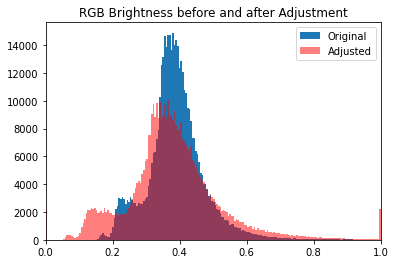

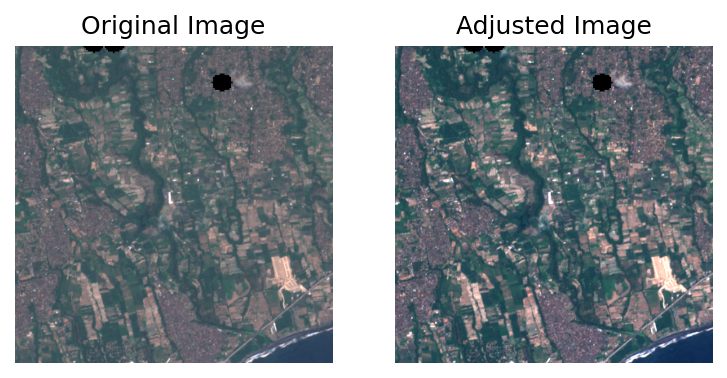

In [352]:
min_val = 0.1
max_val = 0.75
gamma = 1.2

original_image = rgb_stack[0]

edges, bins, patches = plt.hist(original_image.flatten(), 
                                bins=500, 
                                label='Original')

adjusted_image = stretch_histogram(original_image, min_val, max_val) ** gamma
plt.hist((adjusted_image).flatten(), 
         bins=bins, 
         alpha=0.5, 
         color='r',
         label='Adjusted')

plt.xlim([0, 1])
plt.legend()
plt.title('RGB Brightness before and after Adjustment')
plt.show()

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(np.clip(original_image, 0, 1), vmin=0, vmax=1)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(adjusted_image, vmin=0, vmax=1)
plt.title('Adjusted Image')
plt.axis('off')
plt.show()

### Save Images

In [316]:
threshold = 0.8
data_dir = os.path.join('figures/time_series/', name)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)


for i, month in enumerate(dates_list):
    rgb_img = (stretch_histogram(rgb_stack[i], min_val, max_val) ** gamma
    
    # if an image has too much cloud cover, the median rgb color will be low
    if np.median(rgb_img) > 0.1:
        bgr_img = green_blue_swap(rgb_img)
        width, height, channels = np.shape(bgr_img)
        pred_img = preds_stack[i]
        
        # points below threshold are set to black
        pred_img[pred_img < threshold] = 0
        filtered_preds = filter_small_points(pred_img)
        data = np.zeros((width, height, 4))
        # Create an array that is fully black. Set opacity to prediction value
        data[:,:,3] = 255 * filtered_preds
        
        cv2.imwrite(os.path.join(data_dir, f'{name}_pred_{month}.png', data))
        cv2.imwrite(os.path.join(data_dir, f'{name}_rgb_{month}.png', 255 * bgr_img)